# Free Energy Calculations
In this Notebook, we want to give a short glimpse on Free Energy Calculations with Ensembler.

Free energies are an very important topic in computational chemistry. As they are fundamental to thermodynamics and can give a lot of information for different changes to a system. Generally we can destinguish three types of free energies: thermodynamic, conformational and alchemical.
The thermodynamic category is a free energy difference related to a change of an thermodynamic property of the system. The conformational free energy difference can be used to describe a conformational change of a molecule (phase space areas) and the alchemical free energy is describing a change in the chemical space of the molecule (e.g.: methylation).

To calculate a free energy can be very tricky. A challenge might be sampling convergence due to high energy barriers or entropy differences.

To be able to estimate the influence of a chemical change, one needs to calculate the free energies of both so called states.




Here we calculate the Free Energy as:

$F_i = V_i - T_i  S_i = -\beta \ln(Z_i)$



Or we can use the statistical approach:

$F_i(t) = -\frac{1}{\beta}  \ln(\langle e^{-\beta H_i(t)}\rangle_i)$

With the Gibbs Free Energy of state i and state J we can get the Free Energy Difference of the change.

$\Delta F_{ij} = F_j - F_i = -\beta \ln(\frac{Z_i}{Z_j})$

This allows us to estimate the influence of the change.

A free energy Calculation can be described contains three parts:
* The System: Normally these contian multiple states.
* The Sampling Method: The way how the Free Energy landscape will be integrated.
* The Free Energy Estimator: The way, the free energy will be derived from the simulation.


In this notebook we will cover following methods:
* Free Energy Pertubation
  * Zwanzig
  * BAR
* linear coupling
    * FEP with 10 $\lambda$-points
    * TI with 10 $\lambda$-points
* exponential coupling
    * EDS
* hybrid coupling
    * $\lambda$-EDS
* Enhanced Sampling methods:
    * Conveyor Belt
    * RE-EDS


## References:
   - A good Book: Molecular Modelling Principles and Applications A. R. Leach
   - A good page to learn about free energies: http://www.alchemistry.org
   - Thesis: Development and Application of Free-energy Calcuation Methods based on Molecular Dynamics Simulations, D. F. Hahn, Diss. ETH NO. 25914

Maintainers: [@SchroederB](https://https://github.com/SchroederB), [@linkerst](https://https://github.com/linkerst), [@dfhahn](https://https://github.com/dfhahn)

In [1]:
#Here some imports:

##System Path
import os, sys
path = os.getcwd()+"/.."
sys.path.append(path)

##basics
import numpy as np
from matplotlib import pyplot as plt

##Ensembler
from ensembler.analysis.freeEnergyCalculation import zwanzigEquation, threeStateZwanzig, bennetAcceptanceRatio

from ensembler.potentials import OneD as pot
from ensembler.samplers.stochastic import metropolisMonteCarloIntegrator
from ensembler.system.basic_system import system
from ensembler.system.perturbed_system import perturbedSystem
from ensembler.system.eds_system import edsSystem

#Enhanced sampling methods
from ensembler.ensemble import replica_exchange
from ensembler.ensemble import replicas_dynamic_parameters as cvb


from ensembler.visualisation.plotSimulations import oneD_simulation_analysis_plot

import matplotlib
from ensembler.visualisation import style
from ensembler.visualisation import plot_layout_settings
for key, value in plot_layout_settings.items():
    matplotlib.rcParams[key] = value


## Benchmarking parameters
Here we define some parameters that allow us an easier comparison of the different methods.

In [2]:
steps = simulation_steps_total_per_approach = 100#00 #more steps better free energies, but if you just want to try 1000 ist quite fast.
equilibration_steps = simulation_steps_total_per_approach//10

space_range = [-5, 5] #This defines our one dimensional coordinate space
temperature = 30 # for the metropolis criterion of MMC sampler
sampler = metropolisMonteCarloIntegrator(step_size_coefficient=1) # With this algorithm wer are going to sample the potentials


## The Test System: Setting up a System
In the follwoing a test system is setup, for the Free Energy Calculations. For this Notebook, we want to keep it simple.
Therefore two 1D-Harmonic Oscillators with different shifted minima and force constants shall be perfect for us.
These two harmonic oscillators could for example describe the difference of two bonds types.


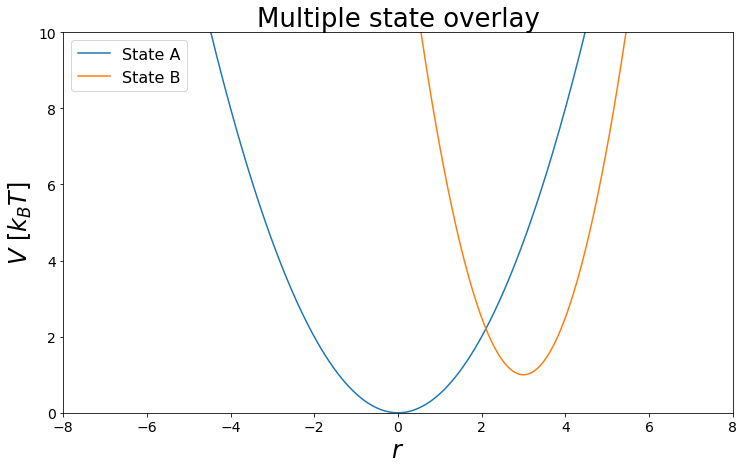

In [3]:
#Build System
#System Parameters:
yoff1 = 0
xoff1 = 0
force_constant = k1 = 1

entropic_difference = k2 = 3
potential_difference = yoff2 = 1
phase_space_distance = xoff2 = 3

#State Potentials
V_A = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1)
V_B = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

#Visualize
from ensembler.visualisation.plotPotentials import multiState_overlays

fig, _ = multiState_overlays([V_A,V_B])


## The Analyctical Solution: Nice if there is one
The Analytical solution for our problem can be calculated from the free energy of harmonic oscillators using

$F_i  = V_i - \frac{1}{2*\beta} log(\sqrt{\frac{2 \pi}{k_i \beta}})$.


As we know all parameters of the harmonic oscillators, we simply can calculate $F_i$ and $F_j$.
The difference of both quantities then results in the final free energy difference:

$\Delta F_{ij} = F_j - F_i$


In [4]:
#Analytical Solution
beta = 1 # beta is in kT

F_A = yoff1 -(1/(2*beta)) * np.log(np.sqrt((2*np.pi)/(k1*beta)))
F_B = yoff2 -(1/(2*beta)) * np.log(np.sqrt((2*np.pi)/(k2*beta)))
dF_AB_expected = F_B-F_A

print("expected dF: ", dF_AB_expected)

expected dF:  1.2746530721670273


For this toy example it was easy to calculate the free energy difference.
But there is not always an analytical solution our problem.
As the functional of a problem gets more complex we can not rely on an analytical solution anymore.
In the following we are going to discuss some methods, that can be used in cases like this.

## Free Energy Pertubation - BAR/Zwanzig: a simplistic start
The journey through the free energy method landscape is started with a simple start; The Free Energy Pertubation method.
As we now assume to not know the analytical solution, we could for example use one state and simulate it, to explore its potential landscape.
If the phase space overlap of both states is high, we could sample all the important information for both states, from this one simulation.


### Sampling
Now we build first the two systems and run the simulations.

Simulation:  Simulation: 100%|██████████| 100/100 [00:00<00:00, 5046.75it/s]


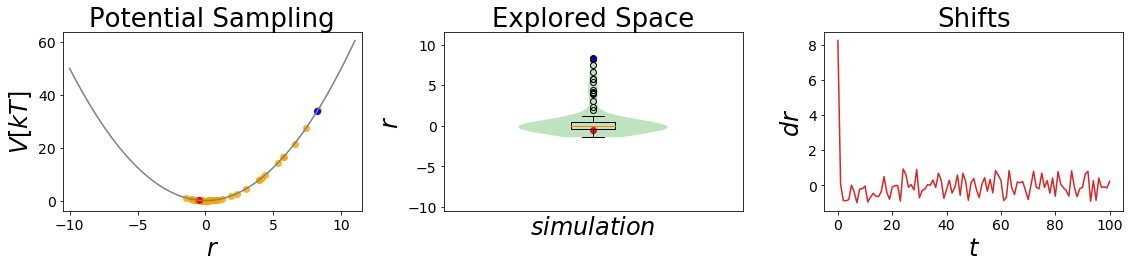

In [5]:
#Simulate the two states:
##Build Systems
systemA = system(potential=V_A, sampler=sampler, temperature=temperature)
systemB = system(potential=V_B, sampler=sampler, temperature=temperature)

##Simulate:
systemA.simulate(steps)
stateA_traj = systemA.trajectory
_ = oneD_simulation_analysis_plot(systemA, limits_coordinate_space=np.linspace(-10,10) )

### Analysis
After simulating state A, the potential energies for state B can be calculated using our potential fuction.

#### Zwanzig Equation
The Zwanzig equation is calculating the free energy difference of two states (A and B) sampled as an ensemble of one of the states (here A). The difference is boltzman-reweighted to increase the weight on the likely/favourable configurations.

$dF_{ij_{Zwanzig}}(V_i, V_j) = - \beta \ln(\langle e^{-\beta(V_j-V_i)} \rangle_i )$

In [6]:
VA_sampled_energies=stateA_traj.total_potential_energy[equilibration_steps:]
VB_sampled_energies=V_B.ene(stateA_traj.position[equilibration_steps:])

zwanz = zwanzigEquation(kT=True)
dF_AB_zwanzig = zwanz.calculate(Vi=VA_sampled_energies, Vj=VB_sampled_energies)

print("Expected Result: ", dF_AB_expected)
print("Zwanzig Result: ", dF_AB_zwanzig)
print()
print("Difference:", dF_AB_zwanzig - dF_AB_expected)


Expected Result:  1.2746530721670273
Zwanzig Result:  -1.0673475731663553

Difference: -2.342000645333383


#### Bennet Acceptance Ratio (BAR)
BAR requires one simulation of each state, to calculate the optimal path between both states. This is done in an iterative fashion. Usually BAR tends to give more accurate results than the Zwanzig approach.

Equation:
$dF_{ij_{BAR}}(V_i, V_j) = \ln(\frac{\langle f(V_i-Vj+C) \rangle_j}{\langle f(V_j-V_i-C) \rangle_i}) + C - ln(\frac{n_1}{n_0})$

with f as fermi function:
- $f(x) = \frac{1}{1+e^{-\beta x}}$

$dF_{ij_{BAR}}$ is calculated iterativley with $ddF_{ij_{BAR}}(V_i, V_j)$, till convergence

Simulation:  Simulation: 100%|██████████| 100/100 [00:00<00:00, 127.16it/s]


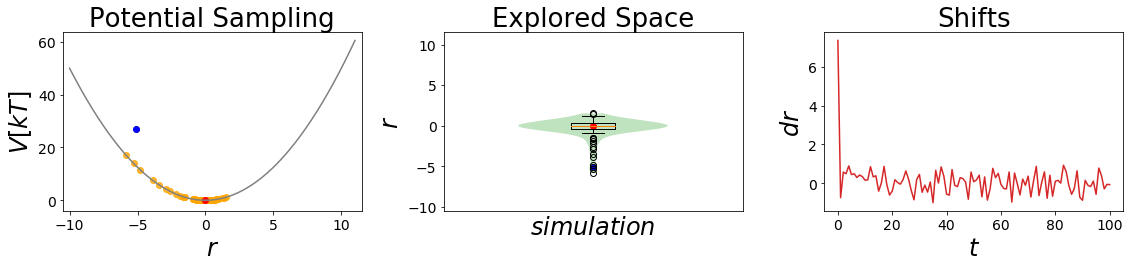

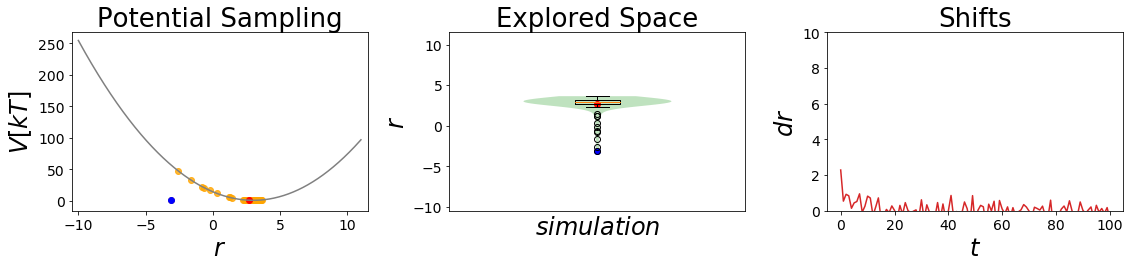

In [7]:
#Simulate the two states:
##Build Systems

systemA = system(potential=V_A, sampler=sampler, temperature=temperature)
systemB = system(potential=V_B, sampler=sampler, temperature=temperature)

##Simulate:
systemA.simulate(steps, withdraw_traj=True, init_system=True)
stateA_traj = systemA.trajectory
_ = oneD_simulation_analysis_plot(systemA, limits_coordinate_space=np.linspace(-10,10))

systemB.simulate(steps, withdraw_traj=True, init_system=True)
stateB_traj = systemB.trajectory

#visualize
_ = oneD_simulation_analysis_plot(systemB, limits_coordinate_space=np.linspace(-10,10))
plt.ylim([0,10])
pass

Text(0.5, 1.0, 'single state simulations')

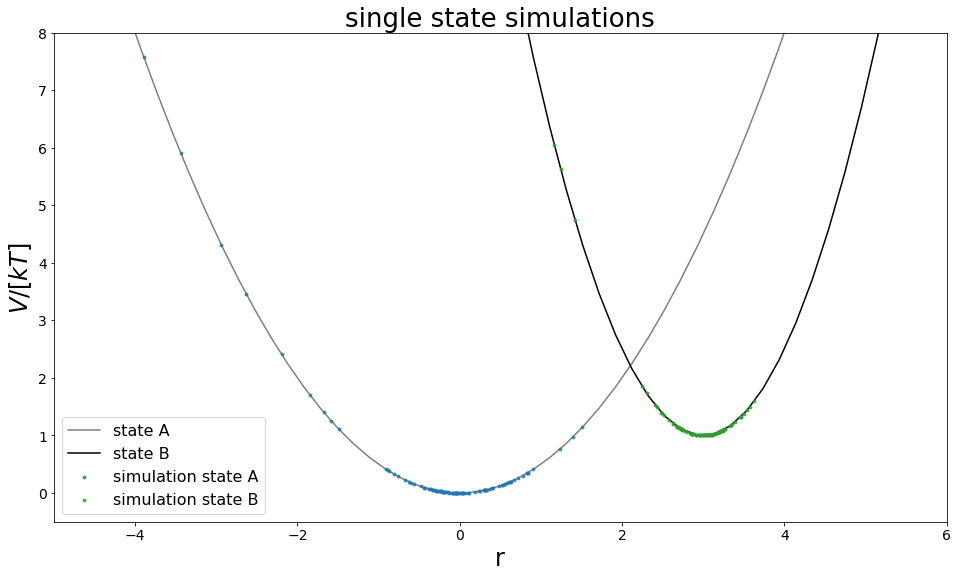

In [8]:
from ensembler import visualisation

positions = np.linspace(-10,10, 100)
fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
traj_pos = list(systemA.trajectory.position)
ax[0].plot(positions, systemA.potential.ene(positions), c="grey", label="state A", zorder=-10)
ene = systemA.potential.ene(traj_pos)
ax[0].scatter(traj_pos, ene, c="C0",alpha=0.8, label="simulation state A",s=8)
ax[0].set_ylim([0,8])

positions = np.linspace(-10,10, 100)
traj_pos = list(systemB.trajectory.position)
ax[0].plot(positions, systemB.potential.ene(positions), c="black", label="state B", zorder=-10)
ene = systemB.potential.ene(traj_pos)
ax[0].scatter(traj_pos, ene, c="C2",alpha=0.8, label="simulation state B",s=8)

ax[0].set_ylim([-0.5,8])
ax[0].set_xlim([-5,6])
ax[0].set_xlabel("r")
ax[0].set_ylabel("$V/[kT]$")
ax[0].legend()
ax[0].set_title("single state simulations")
#fig.savefig("freeEnergyPertubation.pdf")

In [9]:
#Sampling l1
V11=V_A.ene(stateA_traj.position)
V21=V_B.ene(stateA_traj.position)

#Sampling l2
V12=V_A.ene(stateB_traj.position)
V22=V_B.ene(stateB_traj.position)

bar = bennetAcceptanceRatio(kT=True, convergence_radius=0.01, max_iterations=1000)
dF_AB_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22, verbose=True)

print()
print("Expected Result: ", dF_AB_expected)
print("BAR Result: ", dF_AB_bar)
print()
print("Difference:", dF_AB_bar - dF_AB_expected)


Iterate: 	convergence raidus: 0.01
Iteration: 0	dF: 5.312159617709778 	convergence 5.312159617709778
Iteration: 1	dF: 6.30192824866377 	convergence 0.9897686309539919
Iteration: 2	dF: 6.843891407476693 	convergence 0.5419631588129228
Iteration: 3	dF: 7.143907240693938 	convergence 0.30001583321724556
Iteration: 4	dF: 7.311132130071263 	convergence 0.16722488937732471
Iteration: 5	dF: 7.4051820596147255 	convergence 0.0940499295434627
Iteration: 6	dF: 7.45844778962537 	convergence 0.053265730010644496
Iteration: 7	dF: 7.488752609194908 	convergence 0.030304819569537678
Iteration: 8	dF: 7.506041889052739 	convergence 0.01728927985783102
Iteration: 9	dF: 7.515921769607192 	convergence 0.009879880554453102

Final Iterations:  9  Result:  7.515921769607192

Expected Result:  1.2746530721670273
BAR Result:  7.515921769607192

Difference: 6.241268697440164


## Coupling Methods
If the phase space overlap of the two state is low, the free energy estimate might deviate a lot from the real result.
This issue can be solved by coupling the phase space of the two states in a simulation.
Two ways of coupling will be discussed.
The first one is $\lambda$-coupling which forms a linear combination of the two states, this is used for EXP and TI.
Second there is the exponential boltzmann coupling used in enveloping distribution sampling (EDS).

### $\lambda$ - Coupling
One way of coupling two states is to generate the linear combination of the hamiltonians and coupling them by a variable $\lambda$. A $\lambda=0$ corresponds here to state A and a $\lambda=1$ corresponds to state B. The equal mixutre is gained with $\lambda=0.5$. All other lambda values in between $[0,1]$ result in intermediate states, that can be used to bridge the two states phase space.
In the following we are going to build 10 lambda windows linearly distributed from 0 to 1. These will be used for simulations, that are finally analyzed by Zwanzig (resulting in EXP/Free energy pertubation (FEP) method) or thermodynamic integration (TI).

Functional:

$H_{\lambda} = (1-\lambda) H_A + \lambda H_B$

### Build System

Text(0.5, 1.0, 'Sampled Potentials')

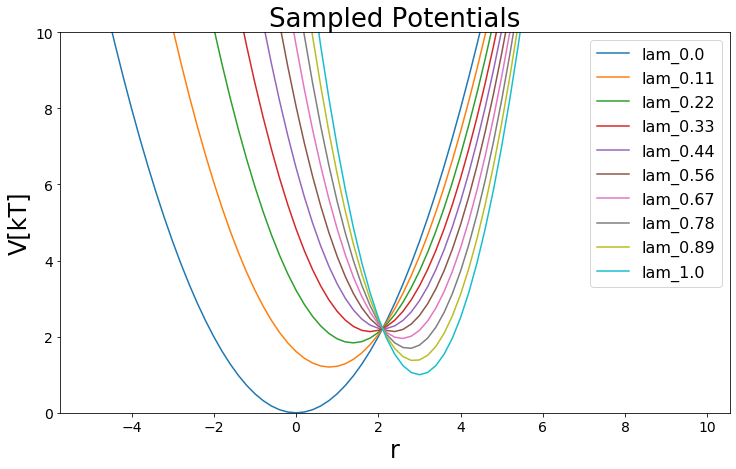

In [10]:
#Build Potential
V_perturbed = pot.linearCoupledPotentials(Va=V_A, Vb=V_B)

#Visualize
lambda_points = 10
positions = np.arange(-5,10, 0.2)
lambda_windows=np.linspace(0,1, lambda_points)

for lam in lambda_windows:
    V_perturbed.set_lambda(lam)
    ene =  V_perturbed.ene(positions)
    plt.plot(positions,ene, label="lam_"+str(round(lam, 2)))

plt.legend()

plt.ylim([0,10])
plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

### Sampling
let's run simulations for all generated intermediate states:

In [11]:
perturbed_system = perturbedSystem(potential=V_perturbed, sampler=sampler, temperature=temperature)

system_trajs = {}
for lam in lambda_windows:
    perturbed_system.lam =lam 
    perturbed_system.simulate(steps, withdraw_traj=True, init_system=True)
    system_trajs.update({lam: perturbed_system.trajectory})


Simulation:  Simulation: 100%|██████████| 100/100 [00:00<00:00, 2969.44it/s]


### Analysis

Sampling first we check the sampling

(-5, 6)

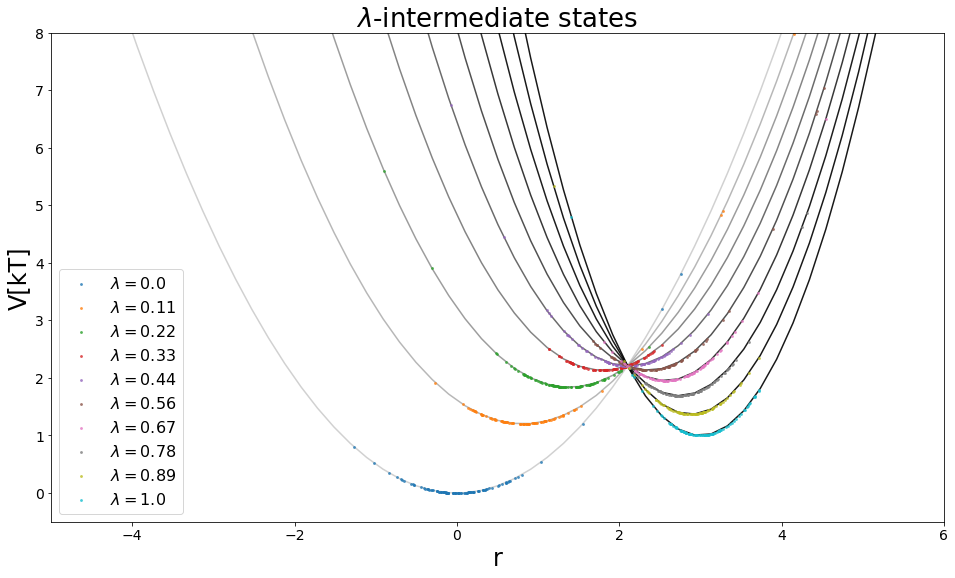

In [12]:
from ensembler import visualisation
from matplotlib import cm
#Visualize
positions = np.linspace(-10, 10, 100)
y_range = [-0.5, 8]


fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
axes = list([axes])
enes = []
all_lams = sorted(list(system_trajs.keys()))

for lamI in all_lams:
    trajI = system_trajs[lamI]
    V_perturbed.set_lambda(lamI)
    ene =  V_perturbed.ene(positions)
    enes.append(ene)
    if(lamI==1):
        c="black"
    else:
        c = cm.get_cmap("binary")(lamI+0.2)

    axes[0].plot(positions,ene, c=c, zorder=-10,alpha=0.9)
    axes[0].scatter(trajI.position, V_perturbed.ene(trajI.position),s=8,alpha=0.8, linewidths=0,
                    label="$\lambda=$"+str(round(lamI, 2)),)#c="orange")

logExp=list(map(lambda x: np.log(np.exp(x)), enes))

axes[0].legend()
axes[0].set_ylim(y_range)

axes[0].set_ylabel("V[kT]")
axes[0].set_xlabel("r")
axes[0].set_title("$\lambda$-intermediate states")

axes[0].set_xlim([-5,6])


### EXP/FEP with multiple lambda windows:
This method is calculating the energy difference between the different $\lambda$-points using the Zwanzig equation leading to a path from state A to state B.


Expected Result:  1.2746530721670273
Sum of intermediates Result:  0.7509801133760812

Difference: -0.5236729587909461


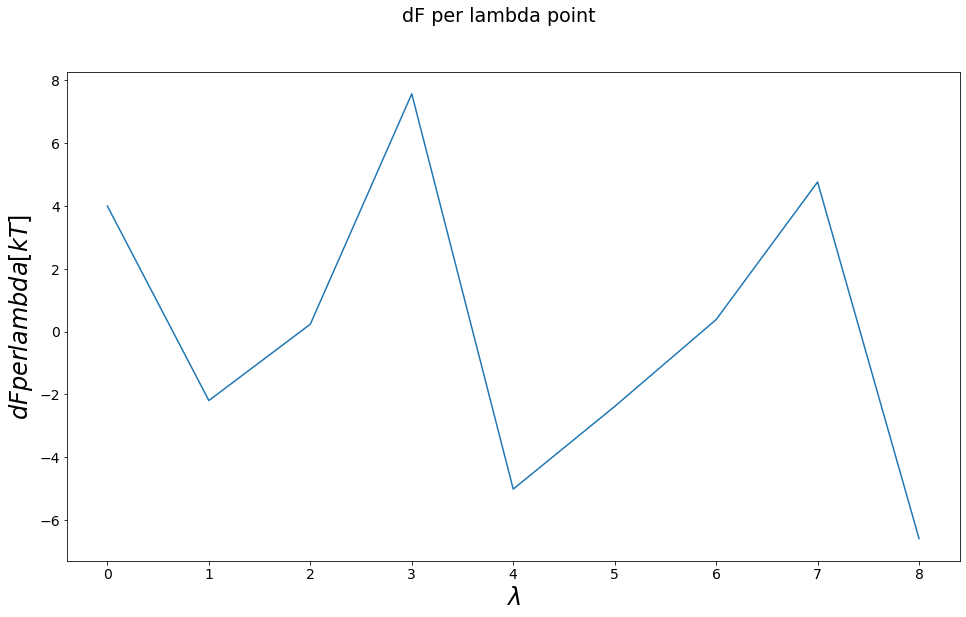

In [13]:
dA_i_fw = []
zwanz = zwanzigEquation()
all_lams = list(sorted(list(system_trajs.keys())))
for lamI, lamJ in zip(all_lams, all_lams[1:]):
    trajI = system_trajs[lamI]
    trajJ = system_trajs[lamJ]

    Vi_fw = trajI.total_potential_energy
    Vj_fw = trajJ.total_potential_energy


    dF_zwanzig_fw = zwanz.calculate(Vi=Vi_fw, Vj=Vj_fw)

    dA_i_fw.append(dF_zwanzig_fw)

fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
axes.plot(dA_i_fw)
axes.set_ylabel("$dFper lambda [kT]$")
axes.set_xlabel("$\lambda$")

fig.suptitle("dF per lambda point")

dF_AB_FEP_10lambda = np.sum(dA_i_fw)

print()
print("Expected Result: ", dF_AB_expected)
print("Sum of intermediates Result: ", dF_AB_FEP_10lambda)
print()
print("Difference:", dF_AB_FEP_10lambda - dF_AB_expected)


#### Thermodynamic Integration (TI)
TI calculates the partial derivative $\langle \frac{\partial H}{\partial \lambda} \rangle_\lambda$ for each $\lambda$-intermediate state and finally integrates over all intermediat states to retain the final free energy difference.

$\int_0^1\langle \frac{\partial H}{\partial \lambda} \rangle_{\lambda} d\lambda$

Text(0.5, 0.98, '$dH/d\\lambda$ for each Lambda point')

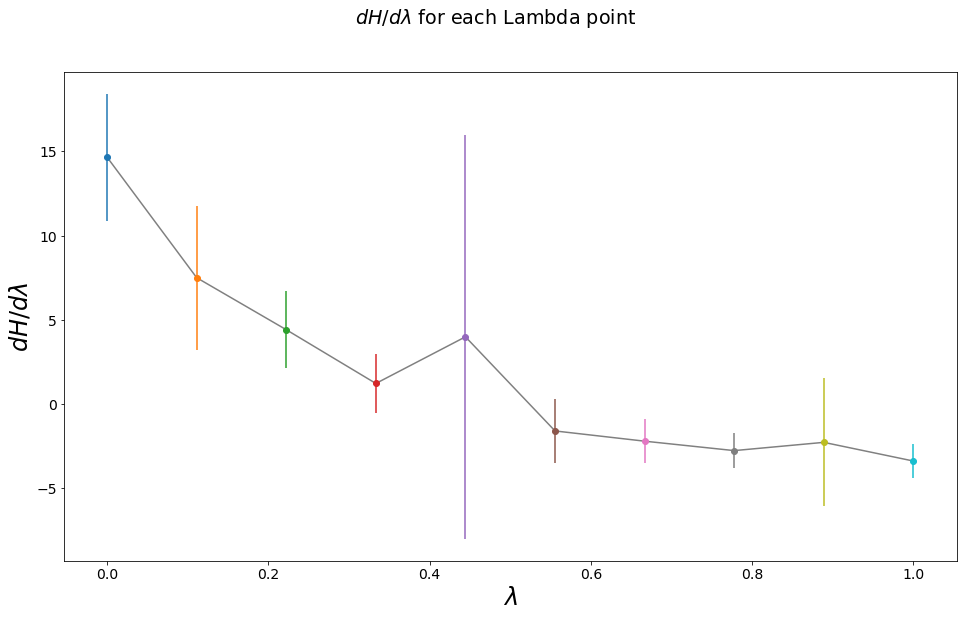

In [14]:
fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)

lam_stats = {}
for lam in system_trajs:
    lam_mean, lam_std = np.mean(system_trajs[lam].dhdlam[equilibration_steps:]), np.std(system_trajs[lam].dhdlam[equilibration_steps:])
    lam_stats.update({lam:{"mean":lam_mean, "std": lam_std}})

    axes.scatter(lam, lam_mean)
    axes.errorbar(lam, lam_mean, lam_std)

axes.plot(sorted(lam_stats), [lam_stats[x]["mean"] for x in sorted(lam_stats)], color="grey", zorder=-1)
axes.set_ylabel("$dH/d\lambda$")
axes.set_xlabel("$\lambda$")

fig.suptitle("$dH/d\lambda$ for each Lambda point")


In [15]:
from scipy import integrate

lam = list(sorted(lam_stats.keys()))
means = [lam_stats[x]['mean'] for x in lam]
stds = [lam_stats[x]['std'] for x in lam]

dF_AB_TI_trapez = integrate.trapz(x=lam, y=means)
dF_AB_TI_trapez_err = integrate.trapz(x=lam, y=stds)

print()
print("Expected Result: ", dF_AB_expected)
print("trapez Rule Result: ", dF_AB_TI_trapez, "+-", dF_AB_TI_trapez_err)
print()
print("Difference:", dF_AB_TI_trapez - dF_AB_expected)



Expected Result:  1.2746530721670273
trapez Rule Result:  1.5341099931896047 +- 3.4204416170439425

Difference: 0.25945692102257745


## State Coupled - Enveloping Distribution Sampling (EDS)

EDS is combining the two physical states into one artificial reference state.

$V_R = -\frac{1}{\beta s} \ln{(e^{-\beta s (V_A-E_A^R)}+e^{-\beta s (V_B-E_B^R)})}$,

with $s$ as the smoothing parameter, $E_X^R$ as the energy offset vector, and $\beta = \frac{1}{k_B T}$ with $k_B$ as Boltzmann constant and $T$ as temperature.

the $s$ parameter is used to smooth the barriers of reference state and the $E_X^R$ vector is used to align the two states in the reference state to each other. Both parameters are crucial for enabling the sampling of all states during a simulation over the reference state.

For more info see the Example_EDS jupyter notebook.

### Build System

Text(0.5, 1.0, 'Sampled Potentials')

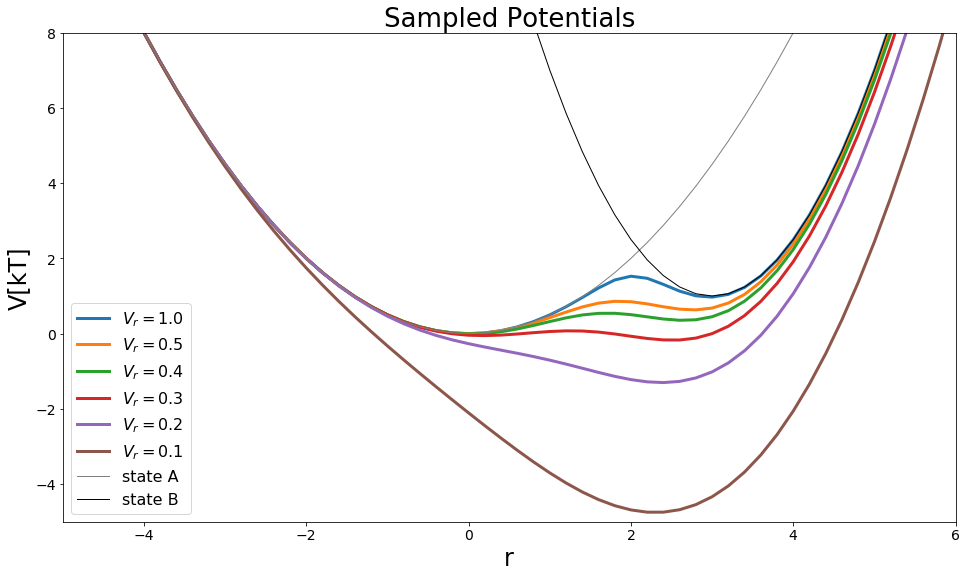

In [16]:
#Build Potential
s=1
Eoff = [0, 0]
V_eds = pot.envelopedPotential(V_is=[V_A,V_B] , s=s, eoff=Eoff)
s_values = np.array([ 1,0.5, 0.4, 0.3, 0.2, 0.1])

#Visualize
positions = np.arange(-10,15, 0.2)
fig = plt.figure(figsize=[16,9])

for s in s_values:
    V_eds.s=s
    plt.plot(positions,V_eds.ene(positions), lw=3, label="$V_r="+str(round(s,3))+"$")

plt.plot(positions,V_A.ene(positions), label="state A", lw=1, color="grey")
plt.plot(positions,V_B.ene(positions), label="state B", lw=1, color="black")

V_eds.s=0.3
plt.legend()
plt.ylim([-5,8])
plt.xlim([-5,6])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

### Sampling
The reference state is sampled here with Metropolis-Monte-Carlo algorithm, and at an feasible s-value, which was found by try and error.

In [17]:
good_s_value=0.3
eds_system = edsSystem(potential=V_eds, sampler=sampler, eds_s=good_s_value, eds_Eoff=Eoff, temperature=temperature)

eds_system.simulate(steps, withdraw_traj=True, init_system=True)
eds_traj = eds_system.trajectory

Simulation:  Simulation: 100%|██████████| 100/100 [00:00<00:00, 1829.57it/s]


Text(0.5, 1.0, 'EDS')

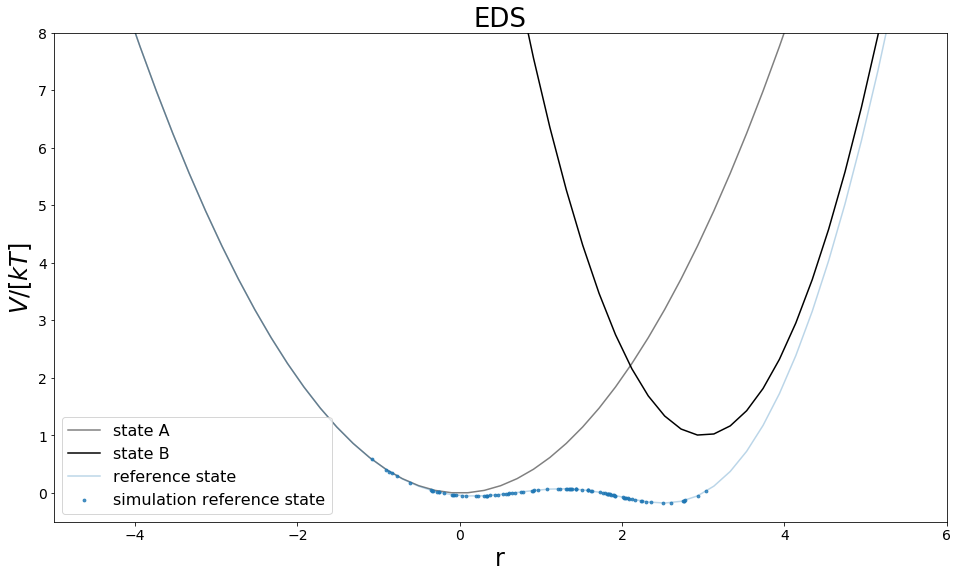

In [18]:

traj = eds_traj.iloc[equilibration_steps:]
positions = np.linspace(-10,10, 100)
V_A_ene = V_A.ene(positions)
V_B_ene = V_B.ene(positions)
V_eds.s = traj.s[equilibration_steps]
eds_ene = V_eds.ene(positions)

traj_pos = list(traj.position)
traj_ene = list(traj.total_potential_energy)

fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
ax[0].plot(positions, V_A_ene, c="grey", label="state A", zorder=-10,)
ax[0].plot(positions, V_B_ene, c="black", label="state B", zorder=-10)
ax[0].plot(positions, eds_ene, c="C0", label="reference state", zorder=-10,alpha=0.3)

ax[0].scatter(traj_pos, traj_ene, c="C0",alpha=0.8, label="simulation reference state",s=8)

ax[0].set_ylim([-0.5,8])
ax[0].set_xlim([-5,6])
ax[0].set_xlabel("r")
ax[0].set_ylabel("$V/[kT]$")

ax[0].legend()
ax[0].set_title("EDS")

### Analysis
In the next step we are going to calculate the free energy from the EDS-simulation.

#### Zwanzig-EDS_Evaluation
In EDS the relative free energy can be calculated using the Zwanzig equation along the Path of state A-> state R -> state B.
As result the free energy difference can be estimated from only one simulation.

In [19]:
rew_zwanz = threeStateZwanzig(kT=True)

traj_positions = eds_traj.position[equilibration_steps:]
Vrr = eds_traj.total_potential_energy[equilibration_steps:]
VAr = V_A.ene(traj_positions)
VBr = V_B.ene(traj_positions)

dF_AB_EDS = rew_zwanz.calculate(Vi=VAr, Vj=VBr, Vr=Vrr)

print("dF ", dF_AB_EDS)
print("deviation: ", dF_AB_EDS-dF_AB_expected)


dF  2.3366227041357663
deviation:  1.061969631968739


#### BAR-EDS_Evaluation
Alternativly also BAR can be applied to calculate the free energy difference. The only requirement is to have two additional simulations of the two pure physical state, like we used in our first approaches.

In [20]:

traj_positions = eds_traj.position[equilibration_steps:]

#Sampling l1
V11=V_A.ene(stateA_traj.position)
V21=V_B.ene(stateA_traj.position)
Vr1 = V_eds.ene(list(stateA_traj.position))

#Sampling l2
V12=V_A.ene(stateB_traj.position)
V22=V_B.ene(stateB_traj.position)
Vr2 = V_eds.ene(list(stateB_traj.position))

Vrr = eds_traj.total_potential_energy[equilibration_steps:]
V1r = V_A.ene(traj_positions)
V2r = V_B.ene(traj_positions)

bar = bennetAcceptanceRatio(kT=True)
setattr(bar, "verbose", False)
#State 1 -> State R
df_AB_BAR_1R = bar.calculate(Vj_i=Vr1, Vi_i=V11, Vi_j=V1r, Vj_j=Vrr, )
#State R -> State 2
df_AB_BAR_R2 = bar.calculate(Vj_i=V2r, Vi_i=Vrr, Vi_j=Vr2, Vj_j=V22)
#State 1 -> State 2
dF_AB_EDS_bar = df_AB_BAR_1R+df_AB_BAR_R2

print("1R", df_AB_BAR_1R, "2R", df_AB_BAR_R2 )
print("dF_BAR:  ", dF_AB_EDS_bar)
print("deviation: ", dF_AB_EDS_bar-dF_AB_expected)






Final Iterations:  5  Result:  -0.5167721401556298

Final Iterations:  5  Result:  2.735161926331498
1R -0.5167721401556298 2R 2.735161926331498
dF_BAR:   2.218389786175868
deviation:  0.9437367140088408


## Hybrid Methods - $\lambda$-EDS

As generalization of EDS and the $\lambda$-coupling $\lambda$-EDS was defined. It combines both methods and behaves like EDS with $\lambda=0.5$ and represents state A with $\lambda = 0$ and state B with $\lambda = 1$.
Additionally the EDS parameters can be used for modifying the potentials.

### Build System

0 	 100.0
1 	 1.0
2 	 0.5
3 	 0.3
4 	 0.2
5 	 0.1


Text(0.5, 1.0, 'Sampled Potentials')

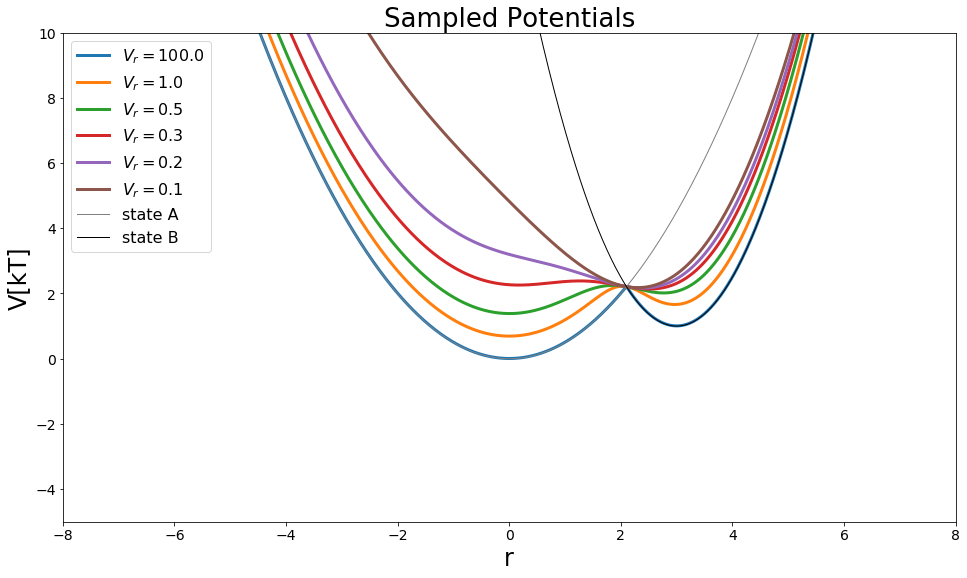

In [21]:
#Build Potential
s=1
Eoff = [0,0]
V_hleds = pot.lambdaEDSPotential(V_is=[V_A,V_B] , s=s, lam=0.5)
s_values = np.array([100, 1, 0.5, 0.3, 0.2, 0.1])

#Visualize
positions = np.linspace(-10,10, 1000)
fig = plt.figure(figsize=[16,9])

for ind,s in enumerate(s_values):
    print(ind, "\t", s)
    V_hleds.s=s
    plt.plot(positions,V_hleds.ene(positions), lw=3, label="$V_r="+str(round(s,3))+"$")

plt.plot(positions,V_A.ene(positions), label="state A", lw=1, color="grey")
plt.plot(positions,V_B.ene(positions), label="state B", lw=1, color="black")


plt.legend()
plt.ylim([-5,10])
plt.xlim([-8,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")


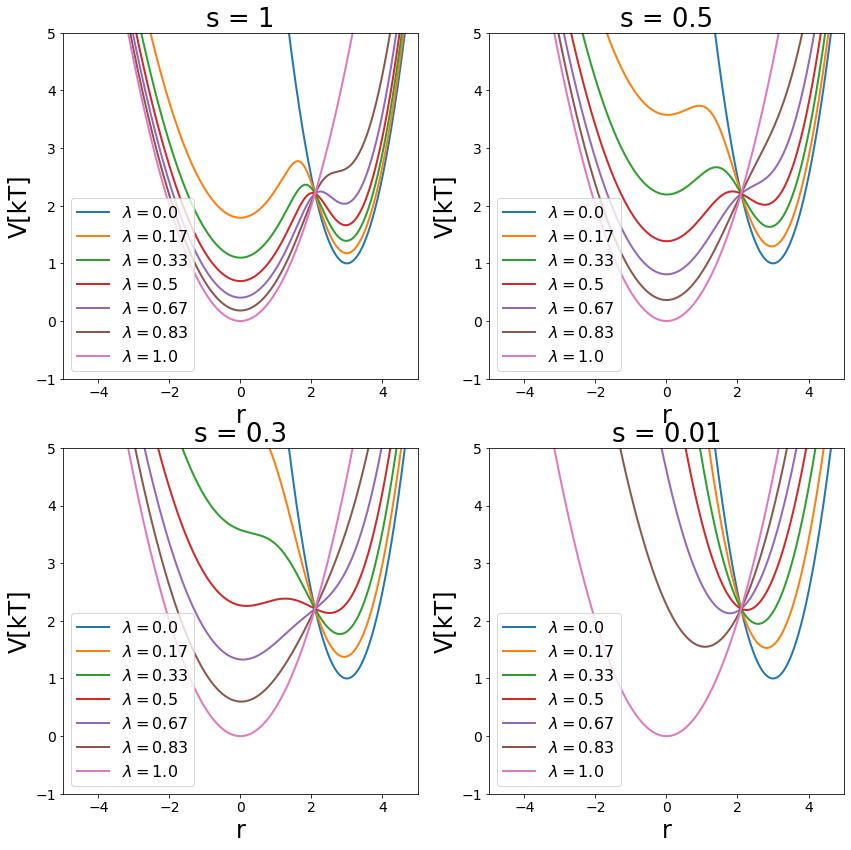

In [22]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[14,14])
axes = np.concatenate(axes)
s_values = [1, 0.5,  0.3, 0.01]
lams=list(sorted(list(np.linspace(start=0, stop=1, num=7))))


for ax, s in zip(axes, s_values):
    V_hleds.s= s
    for ind,lam in enumerate(lams):
        V_hleds.lam=lam
        ax.plot(positions,V_hleds.ene(positions), lw=2, label="$\lambda="+str(round(lam,2))+"$")

    ax.legend()
    ax.set_ylim([-1,5])
    ax.set_xlim([-5,5])

    ax.set_ylabel("V[kT]")
    ax.set_xlabel("r")
    ax.set_title("s = "+str(s))

### Simulate

In [23]:
hleds_system = edsSystem(potential=V_hleds, sampler=sampler, eds_Eoff=Eoff, temperature=temperature)

hleds_simulation_trajs = []
good_s_value = 0.3
hleds_system.set_s(good_s_value)
hleds_system.potential.lam = 0.5
hleds_system.simulate(steps, withdraw_traj=True, init_system=True)
hleds_simulation_traj = hleds_system.trajectory


Simulation:  Simulation: 100%|██████████| 100/100 [00:00<00:00, 1790.37it/s]


In [24]:
#Simulation at other lambdas

hleds_system.potential.lam = 0.25
hleds_system.simulate(steps, withdraw_traj=True, init_system=True)
hleds_simulation_traj2 = hleds_system.trajectory


hleds_system.potential.lam = 0.75
hleds_system.simulate(steps, withdraw_traj=True, init_system=True)
hleds_simulation_traj3 = hleds_system.trajectory

Simulation:  Simulation: 100%|██████████| 100/100 [00:02<00:00, 37.42it/s]


### Analysis
checkout the sampling

Text(0.5, 1.0, '$\\lambda$-EDS')

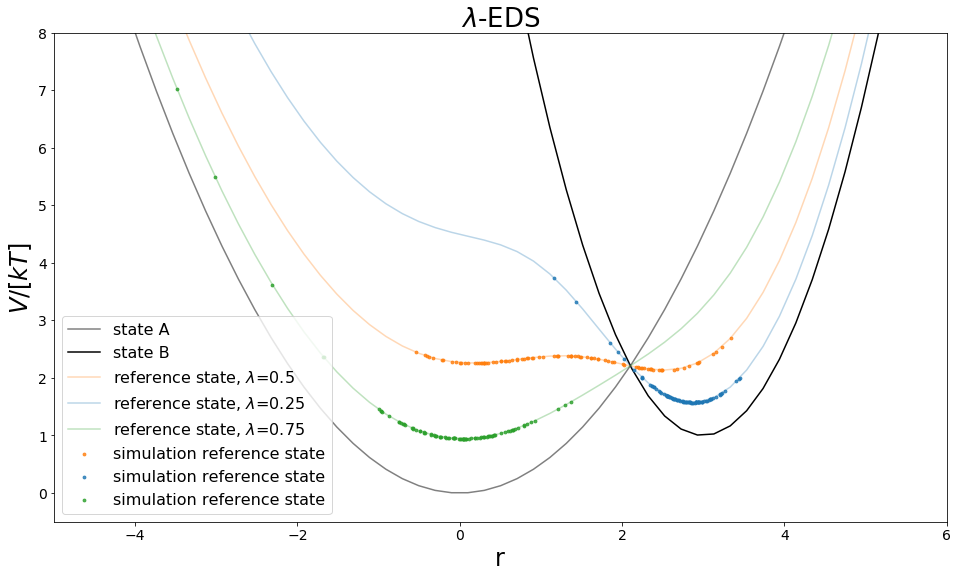

In [25]:
traj = hleds_simulation_traj.iloc[equilibration_steps:]
traj2 = hleds_simulation_traj2.iloc[equilibration_steps:]
traj3 = hleds_simulation_traj3.iloc[equilibration_steps:]

positions = np.linspace(-10,10, 100)
V_A_ene = V_A.ene(positions)
V_B_ene = V_B.ene(positions)
V_hleds.s = traj.s[equilibration_steps]

V_hleds.lam = 0.5
eds_ene = V_hleds.ene(positions)
V_hleds.lam = 0.25
eds_ene1 = V_hleds.ene(positions)
V_hleds.lam = 0.75
eds_ene2 = V_hleds.ene(positions)

traj_pos = list(traj.position)
traj_ene = list(traj.total_potential_energy)
traj_pos2 = list(traj2.position)
traj_ene2 = list(traj2.total_potential_energy)
traj_pos3 = list(traj3.position)
traj_ene3 = list(traj3.total_potential_energy)

fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
ax[0].plot(positions, V_A_ene, c="grey", label="state A", zorder=-10,)
ax[0].plot(positions, V_B_ene, c="black", label="state B", zorder=-10)
ax[0].plot(positions, eds_ene, c="C1", label="reference state, $\lambda$=0.5", zorder=-10,alpha=0.3)
ax[0].plot(positions, eds_ene1, c="C0", label="reference state, $\lambda$=0.25", zorder=-10,alpha=0.3)
ax[0].plot(positions, eds_ene2, c="C2", label="reference state, $\lambda$=0.75", zorder=-10,alpha=0.3)

ax[0].scatter(traj_pos, traj_ene, c="C1",alpha=0.8, label="simulation reference state",s=8)
ax[0].scatter(traj_pos2, traj_ene2, c="C0",alpha=0.8, label="simulation reference state",s=8)
ax[0].scatter(traj_pos3, traj_ene3, c="C2",alpha=0.8, label="simulation reference state",s=8)

ax[0].set_ylim([-0.5,8])
ax[0].set_xlim([-5,6])
ax[0].set_xlabel("r")
ax[0].set_ylabel("$V/[kT]$")

ax[0].legend()
ax[0].set_title("$\lambda$-EDS")

##### Zwanzig Equation
many different free energy calculation methods can by used with $\lambda$-EDS and a certain sampling strategy.
Here we chose the same as for EDS, which should result in a similar free energy difference.

In [26]:
rew_zwanz = threeStateZwanzig(kT=True)
zwanz = zwanzigEquation(kT=True)

traj_positions = hleds_simulation_traj.position[equilibration_steps:]
Vr = hleds_simulation_traj.total_potential_energy[equilibration_steps:]
V1 = V_A.ene(traj_positions)
V2 = V_B.ene(traj_positions)

dF_AB_leds = rew_zwanz.calculate(Vi=V1, Vj=V2, Vr=Vr)

print("dF ", dF_AB_leds)
print("deviation: ", dF_AB_leds-dF_AB_expected)



dF  1.864237147514947
deviation:  0.5895840753479198


## Enhanced Sampling with system Coupling
Enhanced Sampling is a category for methods, that speed up the sampling of a phase space.
These methods can be of course combined with free energy.

Here we are going to show two methods, that are:
* Conveyor Belt TI - a method using a variable $\lambda$-coupling approach (~$\lambda$-dynamics)
* RE-EDS - a combination of hamiltonian replica exchange (HRE) and EDS

Not covered:
* $\lambda$ - HRE-FEP

### Conveyor Belt TI
The conveyor belt TI (CVB-TI) is using a similar building on $\lambda$-dynamics, which allows to run simulations with a changable $\lambda$-parameter.
In CVB-TI multiple replicas are placed onto a conveyor belt, that is accelerated by the derivates of the hamiltonians of each replicas by the $\lambda$-parameter.
This allows for all replicas to sample areas of the $\lambda$-space or even full rotations of the conveyor belt.

#### Build System

In [27]:
num_replicas = 4
trials = simulation_steps_total_per_approach

V_perturbed = pot.linearCoupledPotentials(Va=V_A, Vb=V_B)
lam_system = perturbedSystem(potential=V_perturbed , sampler=sampler, temperature=temperature)
conveyorBelt=cvb.conveyorBelt(capital_lambda=0.0, n_replicas=num_replicas, system=lam_system, build=False)


#### Simulate
here we simulate the conveyorbelt. Every replica does nsteps_between_trials, till the next conveyorbelt rotation update.


In [28]:
conveyorBelt.simulate(trials)
cvb_trajs = conveyorBelt.get_trajectories()



#### Analysis
##### Visualize the sampling of $\lambda$-space
First all replica $\lambda$-trajectories are shown.

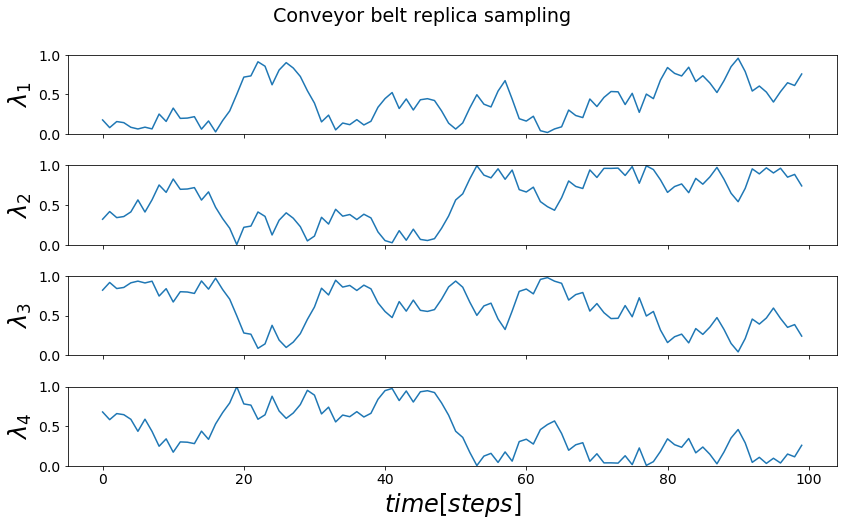

In [29]:
fig, axes = plt.subplots(nrows=4,  sharex=True)
keys=list(sorted(list(cvb_trajs.keys())))
for key in keys:
    axes[key].plot(cvb_trajs[key].lam)
    axes[key].set_ylabel("$\lambda_"+str(key+1)+"$")
    if(key == keys[-1]):    axes[key].set_xlabel("$time [steps]$")
    axes[key].set_ylim([0,1])
fig.suptitle("Conveyor belt replica sampling", y=1.05)
fig.tight_layout()

A histogram of the conveyor belt capital $\lambda$

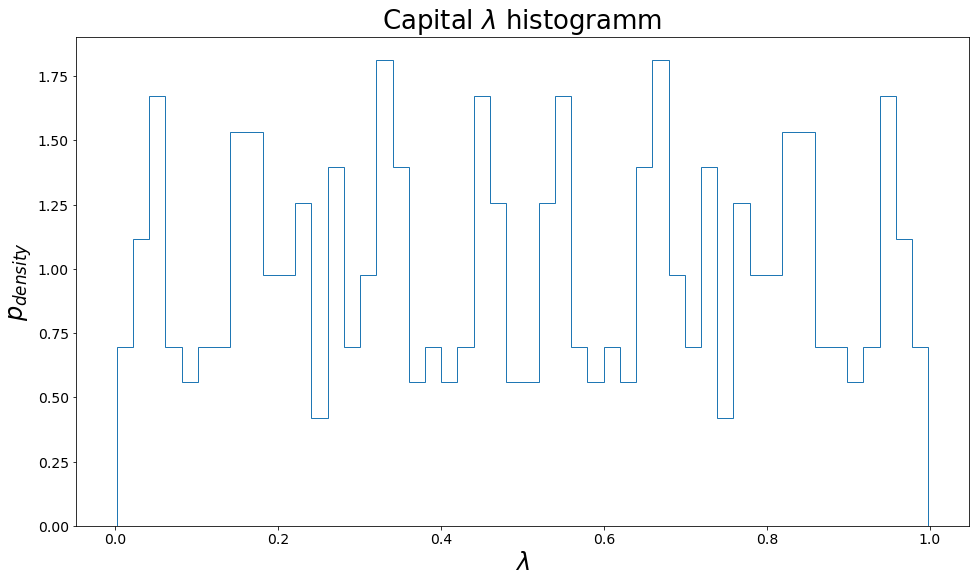

In [30]:
import pandas as pd
nbins=50
mega_traj = pd.concat(list(map(lambda x: x[equilibration_steps:], cvb_trajs.values())), ignore_index=True)

plt.figure(figsize=[16,9])
p, lam_bins, path = plt.hist(list(sorted(np.unique(mega_traj.lam))), bins=nbins, density=True, histtype="step")
plt.xlabel("$\lambda$")
plt.ylabel("$p_{density}$")
plt.title("Capital $\lambda$ histogramm")
pass


##### Visualize the sampling on potential energy functions
like before we can map the sampling, retained for the phase-space.

Text(0.5, 1.0, 'Conveyor Belt Sampling')

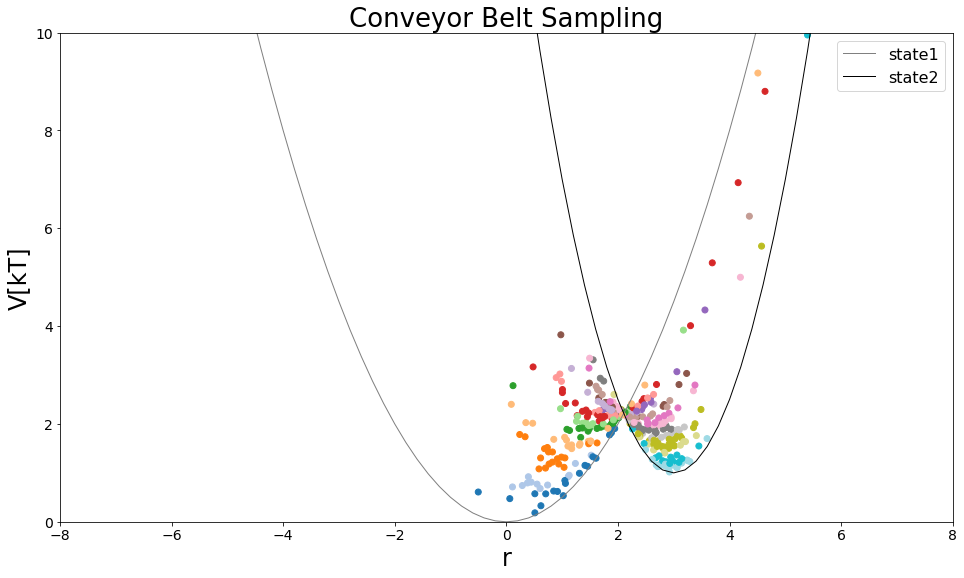

In [31]:
import pandas as pd
mega_traj = pd.concat(list(cvb_trajs.values()), ignore_index=True)

def find_nearest_bin(array,value):
    cbins =[]
    for val in value:
        idx = np.argmin(np.abs(array-val))
        cbins.append(idx)
    return cbins

discrete_traj = np.array(find_nearest_bin(value=mega_traj.lam[equilibration_steps:], array=lam_bins))

fig, axes = plt.subplots(ncols=1, figsize=[16,9])
axes = [axes]
axes[0].scatter(list(mega_traj.position[equilibration_steps:]), mega_traj.total_potential_energy[equilibration_steps:], c=discrete_traj, cmap="tab20")

#State Potentials
V_A = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1)
V_B = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)
positions = np.arange(-10,10, 0.2)
axes[0].plot(positions, V_A.ene(positions), label="state1", lw=1, color="grey")
axes[0].plot(positions, V_B.ene(positions), label="state2", lw=1, color="black")

axes[0].legend()
axes[0].set_ylim([0,10])
axes[0].set_xlim([-8,8])

axes[0].set_ylabel("V[kT]")
axes[0].set_xlabel("r")
axes[0].set_title("Conveyor Belt Sampling")


##### Calculate Free-Energy with TI


Expected Result:  1.2746530721670273
trapez Rule Result:  0.2406082990408867 +- 3.0451131643051697

Difference: -1.0340447731261406


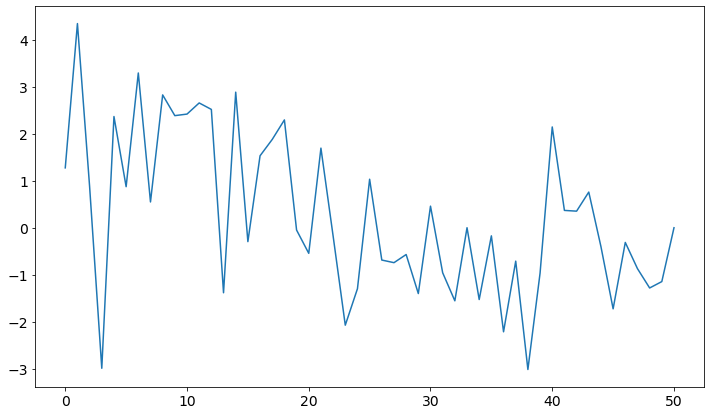

In [32]:
from scipy import integrate

lambda_stat = mega_traj[["lam","dhdlam"]]

means_cvb = np.nan_to_num([np.mean(lambda_stat.loc[np.where(discrete_traj==x+1)].dhdlam) for x in range(nbins+1)])
std_cvb = np.nan_to_num([np.std(lambda_stat.loc[np.where(discrete_traj==x+1)].dhdlam) for x in range(nbins+1)] )

plt.plot(means_cvb)

dF_AB_cvb_trapez = integrate.trapz(x=lam_bins, y=means_cvb)
dF_AB_err = integrate.trapz(x=means_cvb, y=std_cvb)

print()
print("Expected Result: ", dF_AB_expected)
print("trapez Rule Result: ", dF_AB_cvb_trapez, "+-", dF_AB_err)
print()
print("Difference:", dF_AB_cvb_trapez - dF_AB_expected)


### RE-EDS
Replica EDS is a combination of HRE and EDS.
In the HRE the s-parameter is exchanged and therefore different levels of smoothing are sampled in one simulation approach.
This helps with the s-parameter choice, as now a full distribution can be chosen.

#### Build System

DO trials:  5 steps:  20


Text(0.5, 1.0, 'Sampled Potentials')

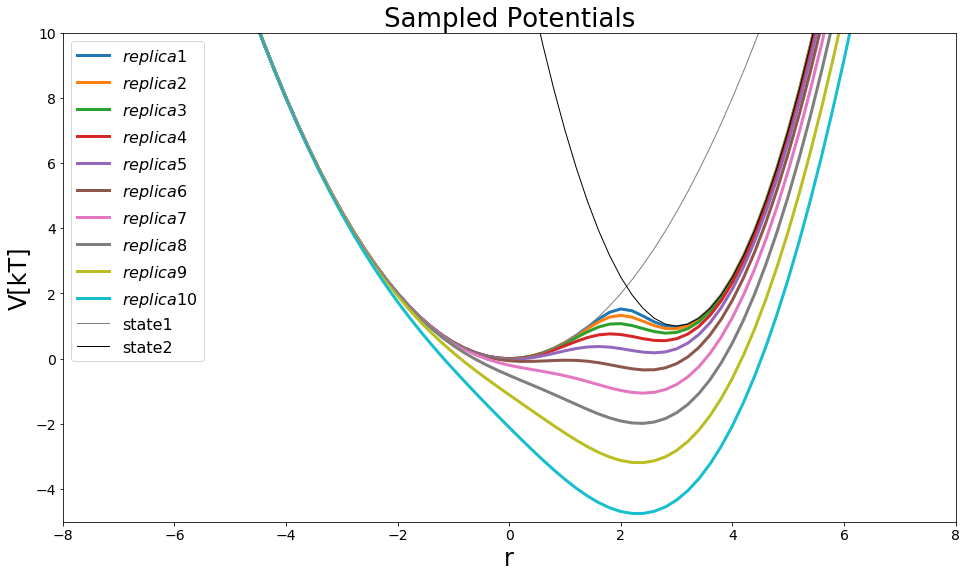

In [47]:
#potential
V_eds = pot.envelopedPotential(V_is=[V_A,V_B])

##System
eds_system = edsSystem(sampler=sampler, potential=V_eds, start_position=4, temperature=temperature)

##Ensemble
##Ensemble Settings:
number_of_replica = 10
s_values = np.logspace(start=0, stop=-1, num=number_of_replica)
steps_between_trials= 20
trials=simulation_steps_total_per_approach//steps_between_trials


print("DO trials: ", trials, "steps: ", steps_between_trials)
ensemble = replica_exchange.replicaExchangeEnvelopingDistributionSampling(system=eds_system, exchange_criterium=None,
                                                                          s_range=s_values, steps_between_trials=steps_between_trials)


#Visualize
positions = np.arange(-10,10, 0.2)
fig = plt.figure(figsize=[16,9])

for ind,replica in ensemble.replicas.items():
    plt.plot(positions,replica.potential.ene(positions), lw=3, label="$replica "+str(ind+1)+"$")

V_eds.i
plt.plot(positions,V_eds.V_is[0].ene(positions), label="state1", lw=1, color="grey")
plt.plot(positions,V_eds.V_is[1].ene(positions), label="state2", lw=1, color="black")


plt.legend()
plt.ylim([-5,10])
plt.xlim([-8,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")


#### Simulate

In [53]:
ensemble.simulate(trials, reset_ensemble=True)
reeds_trajs = ensemble.replica_trajectories


Running trials: 100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


#### Analysis

Text(0.5, 1.0, 'RE-EDS')

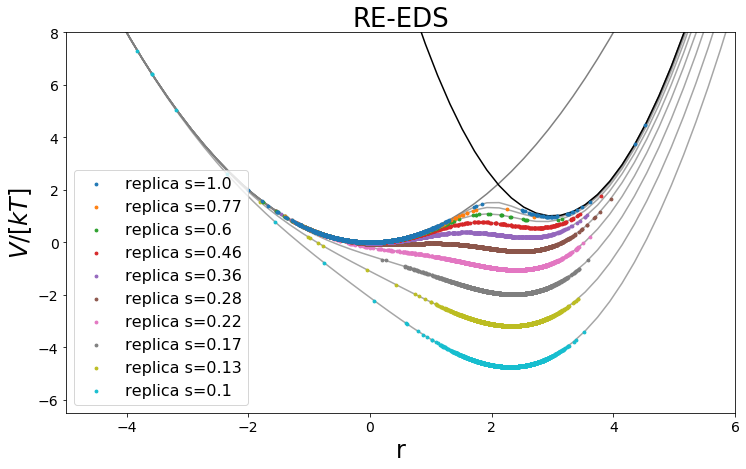

In [54]:

positions = np.linspace(-10,10)
fig, ax = plt.subplots(ncols=1)
keys = sorted(list(reeds_trajs.keys()), reverse=False)

positions = np.linspace(-10,10, 100)
V_A_ene = V_A.ene(positions)
V_B_ene = V_B.ene(positions)

ax.plot(positions, V_A_ene, c="grey", zorder=-10,)
ax.plot(positions, V_B_ene, c="black", zorder=-10)

for traj in keys:
    s =  round(ensemble.replicas[traj].s,2)
    ax.plot(positions, ensemble.replicas[traj].potential.ene(positions), c="grey", alpha=0.7, zorder=-60)
    min_e = np.min(positions)
    ax.scatter(reeds_trajs[traj].position[equilibration_steps:], reeds_trajs[traj].total_potential_energy[equilibration_steps:], zorder=-traj, c="C"+str(traj),s=8, label="replica s="+str(s))

ax.set_ylim([-6.5,8])
ax.set_xlim([-5,6])
ax.set_xlabel("r")
ax.set_ylabel("$V/[kT]$")
ax.legend()
ax.set_title("RE-EDS")

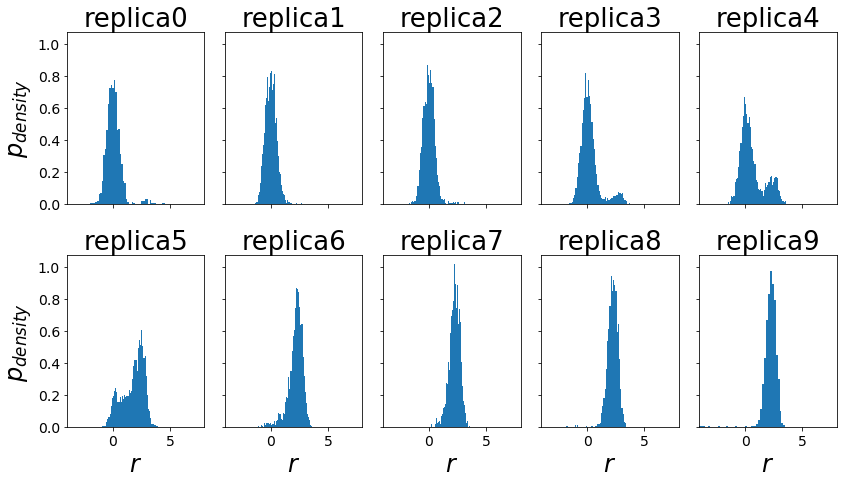

In [55]:
trajs = ensemble.get_trajectories()

positions = np.linspace(-10,10)
nrows = 2
ncols=len(trajs)//nrows

fig, axes = plt.subplots(ncols=ncols, nrows=nrows,  sharex=True, sharey=True)
axes=np.concatenate(axes)

for ind, (traj, ax) in enumerate(zip(reeds_trajs, axes)):
    ax.hist(reeds_trajs[traj].position[equilibration_steps:], bins=50, density=True)
    ax.set_xlim([-4,8])
    ax.set_title("replica"+str(traj))
    if(ind%ncols == 0): ax.set_ylabel("$p_{density}$")
    if(ind>=(nrows-1)*ncols): ax.set_xlabel("$r$")


fig.tight_layout()

#### Visualization of Replica Exchanges
here the Exchanges of the different replicas are shown.


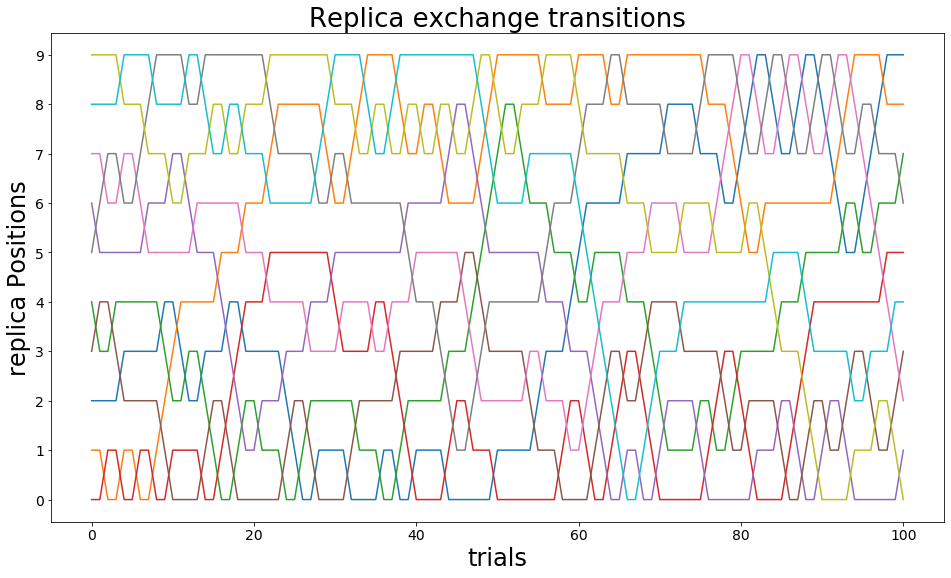

In [56]:

stats= ensemble.exchange_information
replicas = np.unique(ensemble.exchange_information.replicaID)
trials = np.unique(ensemble.exchange_information.nExchange)

import itertools as it

fig, ax = plt.subplots(ncols=1, figsize=[16,9])

replica_positions = {}
for replica in replicas:
    replica_positions.update({replica: stats.loc[stats.replicaID==replica].replicaPositionI})

    x = trials
    y = replica_positions[replica]
    ax.plot(x,y , label="replica_"+str(replica))

#plt.yticks(replicas+1, reversed(replicas+1))
ax.set_yticks(ticks=replicas)
ax.set_yticklabels(labels=replicas)

ax.set_ylabel("replica Positions")
ax.set_xlabel("trials")
ax.set_title("Replica exchange transitions")
if(len(replicas)<10): plt.legend()

In [57]:

rew_zwanz = threeStateZwanzig(kT=True)
zwanz = zwanzigEquation(kT=True)
equilibration_steps=10
#State Potentials
V_A = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
V_B = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

#optimal sampling distribution
opt_samp_fraction = [0.5, 0.5]

min_mae = 100
min_mae_replica = -1

dF_AB_RE_EDS_results = []
s_vals = []
for ind,key in enumerate(reeds_trajs):
    s_vals.append(reeds_trajs[key].s[1])
    traj_positions = reeds_trajs[key].position[equilibration_steps:]
    Vr = reeds_trajs[key].total_potential_energy[equilibration_steps:]
    V1 = V_A.ene(traj_positions)
    V2 = V_B.ene(traj_positions)
    
    #dominant state sampling: 
    min_enes = np.argmin(np.array([V1, V2]).T, axis=1)
    unique, counts = np.unique(min_enes, return_counts=True)
    norm_counts = counts/len(min_enes)
    
    MAE_optimal_sampling = np.mean(np.abs(norm_counts-opt_samp_fraction))
    if(MAE_optimal_sampling<min_mae):
        min_mae = MAE_optimal_sampling
        min_mae_replica = key
        
    dF_AB_RE_EDS_zwanz = rew_zwanz.calculate(Vi=V1, Vj=V2, Vr=Vr)
    dF_AB_RE_EDS_results.append(dF_AB_RE_EDS_zwanz)

print()
print("\tExpected Result: ", dF_AB_expected)
print("s\t\tdF\t\tdiff")
print("\n".join(map(str, ["\t\t".join(map(str, np.round(x,5))) for x in  zip(s_vals, dF_AB_RE_EDS_results, dF_AB_RE_EDS_results - dF_AB_expected)])))
print("\n\n\n")



	Expected Result:  1.2746530721670273
s		dF		diff
1.0		3.94409		2.66944
0.77426		6.85809		5.58344
0.59948		5.60009		4.32544
0.46416		3.17554		1.90089
0.35938		2.66814		1.39348
0.27826		1.05054		-0.22411
0.21544		0.17714		-1.09751
0.16681		-0.17674		-1.45139
0.12915		-0.07538		-1.35003
0.1		1.18102		-0.09363






## Final Results

In [58]:

md_str = "| method | dF  | deviation |\n"
md_str += "|---|---|---|\n"
md_str += "| analytical   | "+str(np.round(dF_AB_expected,2))+"  |   | \n"
md_str += "| Zwanzig   | "+str(np.round(dF_AB_zwanzig,2))+"  | "+str(np.round(dF_AB_zwanzig-dF_AB_expected,2))+" | \n"
md_str += "| BAR   | "+str(np.round(dF_AB_bar,2))+"  | "+str(np.round(dF_AB_bar-dF_AB_expected,2))+" | \n"

md_str += "| FEP 10-$\lambda$ Points   | "+str(np.round(dF_AB_FEP_10lambda,2))+"  | "+str(np.round(dF_AB_FEP_10lambda-dF_AB_expected,2))+" | \n"
md_str += "| TI 10-$\lambda$ Points  | "+str(np.round(dF_AB_TI_trapez,2))+"  | "+str(np.round(dF_AB_TI_trapez-dF_AB_expected,2))+" | \n"

md_str += "| EDS   | "+str(np.round(dF_AB_EDS,2))+"  | "+str(np.round(dF_AB_EDS-dF_AB_expected,2))+" | \n"
md_str += "| EDS-BAR   | "+str(np.round(dF_AB_EDS_bar,2))+"  | "+str(np.round(dF_AB_EDS_bar-dF_AB_expected,2))+" | \n"
md_str += "| $\lambda$ EDS   | "+str(np.round(dF_AB_leds,2))+"  | "+str(np.round(dF_AB_leds-dF_AB_expected,2))+" | \n"

md_str += "| conveyor belt TI   | "+str(np.round(dF_AB_cvb_trapez,2))+"  | "+str(np.round(dF_AB_cvb_trapez-dF_AB_expected,2))+" | \n"
md_str += "| RE-DS   | "+str(np.round(dF_AB_RE_EDS_results[min_mae_replica],2))+"  | "+str(np.round(dF_AB_RE_EDS_results[min_mae_replica]-dF_AB_expected,2))+" | \n"


from IPython.display import display, Markdown, Latex
display(Markdown(md_str))


| method | dF  | deviation |
|---|---|---|
| analytical   | 1.27  |   | 
| Zwanzig   | -1.07  | -2.34 | 
| BAR   | 7.52  | 6.24 | 
| FEP 10-$\lambda$ Points   | 0.75  | -0.52 | 
| TI 10-$\lambda$ Points  | 1.53  | 0.26 | 
| EDS   | 2.34  | 1.06 | 
| EDS-BAR   | 2.22  | 0.94 | 
| $\lambda$ EDS   | 1.86  | 0.59 | 
| conveyor belt TI   | 0.24  | -1.03 | 
| RE-DS   | 1.05  | -0.22 | 
